In [ ]:
import os
from google.colab import files

# Download dataset
os.chdir('/content')
files.upload()  # Upload the kaggle.json file

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d hassan06/nslkdd -p /content/dataset/ --unzip

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

pd.set_option('display.max_columns', None)

# ======================
# Data Loading and Preprocessing
# ======================

# Define column names for the dataset
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

# Load training data
train_df = pd.read_csv('dataset/nsl-kdd/KDDTrain+.txt', names=columns, index_col=False)

# Load test data
test_df = pd.read_csv('dataset/nsl-kdd/KDDTest+.txt', names=columns, index_col=False)

# Combine train and test data for consistent preprocessing
data_df = pd.concat([train_df, test_df], ignore_index=True)

# Drop difficulty level column
data_df = data_df.drop('difficulty_level', axis = 1)

# Drop any columns with only one unique value (if any)
for col in data_df.columns:
    if data_df[col].nunique() == 1:
        data_df.drop(col, axis=1, inplace=True)
        print(f'dropped {col} column since it only has one unique value')

data_df_raw = data_df.copy()

categorical_columns = ['protocol_type', 'service', 'flag', 'label']

# Check the remaining columns (excluding categorical) for their data types
for col in data_df.columns:
    if col not in categorical_columns:
        if not pd.api.types.is_numeric_dtype(data_df[col]):
            print(f"Column '{col}' is not numerical!")

# Check if there are any non-numeric values (like strings or NaNs) in the numerical columns
for col in data_df.columns:
    if col not in categorical_columns:
        non_numeric_values = data_df[col].apply(lambda x: isinstance(x, (int, float)))
        if not all(non_numeric_values):
            print(f"Column '{col}' contains non-numeric values!")

numerical_columns = [col for col in data_df.columns if col not in categorical_columns]

# Identify unique attack types in train and test sets
train_labels = train_df['label'].unique()
test_labels = test_df['label'].unique()

# Find attack types in test set that are not in the train set
unseen_attack_types = set(test_labels) - set(train_labels)
print(f"Number of Unseen attack types in test set: {len(unseen_attack_types)}")

# Replace unseen attack types in the test set with 'other'
data_df['label'] = data_df['label'].apply(lambda x: 'other' if x in unseen_attack_types else x)

# Decide if we want to do 5-class classification
five_class_classification = True
if five_class_classification:
    # Drop the records with label 'other'
    data_df = data_df.loc[data_df['label'] != 'other'].copy()

    def map_to_five_classes(label):
        if label in ['neptune', 'smurf', 'back', 'teardrop', 'pod', 'land']:
            return 'DoS'
        elif label in ['satan', 'ipsweep', 'portsweep', 'nmap']:
            return 'Probe'
        elif label in ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy']:
            return 'R2L'
        elif label in ['buffer_overflow', 'loadmodule', 'rootkit', 'perl']:
            return 'U2R'
        else:
            return 'normal'

    data_df['label'] = data_df['label'].apply(map_to_five_classes)


# Encode categorical columns using LabelEncoder
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data_df[col] = le.fit_transform(data_df[col])
    label_encoders[col] = le  # Save label encoders if needed later for inverse transform

# Calculate the final total number of labels for the task
num_classes = len(np.unique(data_df['label']))
print(f"Final Number of classes to classify: {num_classes}")

# Normalize numerical columns using StandardScaler
scaler = StandardScaler()
data_df[numerical_columns] = scaler.fit_transform(data_df[numerical_columns])

# Split the data back into train and test sets
train_size = len(train_df)
train_data = data_df[:train_size]
test_data = data_df[train_size:]

# Separate features and labels
x_train_categ = train_data[categorical_columns[:-1]].values  # Exclude the 'label' column
x_train_numer = train_data[numerical_columns].values
y_train = train_data['label'].values

x_test_categ = test_data[categorical_columns[:-1]].values  # Exclude the 'label' column
x_test_numer = test_data[numerical_columns].values
y_test = test_data['label'].values

# Print the shapes to verify
print(f"x_train_categ shape: {x_train_categ.shape}")
print(f"x_train_numer shape: {x_train_numer.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test_categ shape: {x_test_categ.shape}")
print(f"x_test_numer shape: {x_test_numer.shape}")
print(f"y_test shape: {y_test.shape}")


dropped num_outbound_cmds column since it only has one unique value
Number of Unseen attack types in test set: 17
Final Number of classes to classify: 5
x_train_categ shape: (125973, 3)
x_train_numer shape: (125973, 37)
y_train shape: (125973,)
x_test_categ shape: (18794, 3)
x_test_numer shape: (18794, 37)
y_test shape: (18794,)


In [2]:
# Print the mapping relationship as one row per pair
for original, encoded in zip(label_encoders['label'].classes_, label_encoders['label'].transform(label_encoders['label'].classes_)):
    print(f"{original} -> {encoded}")

DoS -> 0
Probe -> 1
R2L -> 2
U2R -> 3
normal -> 4


In [3]:
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert the data to PyTorch tensors
x_train_categ_tensor = torch.tensor(x_train_categ, dtype=torch.long)
x_train_numer_tensor = torch.tensor(x_train_numer, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Create a TensorDataset and DataLoader for batching
train_dataset = TensorDataset(x_train_categ_tensor, x_train_numer_tensor, y_train_tensor)

# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for training and validation
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [4]:
!rm transformer.py
!rm ft_transformer.py
!wget https://raw.githubusercontent.com/RealDanielWei/MLModels/master/transformer.py
!wget https://raw.githubusercontent.com/RealDanielWei/MLModels/master/ft_transformer.py


--2024-11-21 06:32:32--  https://raw.githubusercontent.com/RealDanielWei/MLModels/master/transformer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7994 (7.8K) [text/plain]
Saving to: ‘transformer.py’

transformer.py      100%[===================>]   7.81K  --.-KB/s    in 0s      

2024-11-21 06:32:33 (86.8 MB/s) - ‘transformer.py’ saved [7994/7994]

--2024-11-21 06:32:33--  https://raw.githubusercontent.com/RealDanielWei/MLModels/master/ft_transformer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8525 (8.3K) [text/plain]

In [5]:
del model

NameError: name 'model' is not defined

In [6]:
from ft_transformer import FTTransformer

categories = [data_df[col].nunique() for col in categorical_columns[:-1]]  # Unique values per categorical column
num_continuous = len(numerical_columns)  # Number of continuous features

# Initialize FTTransformer with the correct output dimension for multi-class classification
model = FTTransformer(
    categories=categories,      # List of unique values for each categorical feature
    num_continuous=num_continuous,  # Number of continuous features
    dim=10,                    # Embedding dimension
    depth=8,                   # Number of Transformer layers
    heads=4,                   # Number of attention heads
    dim_head=4,               # Dimension of each attention head
    dim_out=num_classes,        # Set output dimension to the number of classes
    num_special_tokens=1,      # Number of special tokens (CLS, etc.)
    attn_dropout=0.1,          # Dropout for attention
    ff_dropout=0.1             # Dropout for feedforward layers
)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters in the model
print(f"Total number of parameters: {count_parameters(model)}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Total number of parameters: 17435


device = cuda
Epoch 1/50
Training Loss: 0.2619
Validation Loss: 0.0765, Accuracy: 0.9828
Model saved with better validation accuracy
Epoch 2/50
Training Loss: 0.0670
Validation Loss: 0.0437, Accuracy: 0.9844
Model saved with better validation accuracy
Epoch 3/50
Training Loss: 0.0402
Validation Loss: 0.0381, Accuracy: 0.9888
Model saved with better validation accuracy
Epoch 4/50
Training Loss: 0.0330
Validation Loss: 0.0298, Accuracy: 0.9908
Model saved with better validation accuracy
Epoch 5/50
Training Loss: 0.0301
Validation Loss: 0.0237, Accuracy: 0.9929
Model saved with better validation accuracy
Epoch 6/50
Training Loss: 0.0262
Validation Loss: 0.0213, Accuracy: 0.9938
Model saved with better validation accuracy
Epoch 7/50
Training Loss: 0.0244
Validation Loss: 0.0196, Accuracy: 0.9944
Model saved with better validation accuracy
Epoch 8/50
Training Loss: 0.0232
Validation Loss: 0.0209, Accuracy: 0.9940
Epoch 9/50
Training Loss: 0.0216
Validation Loss: 0.0180, Accuracy: 0.9942
Epo

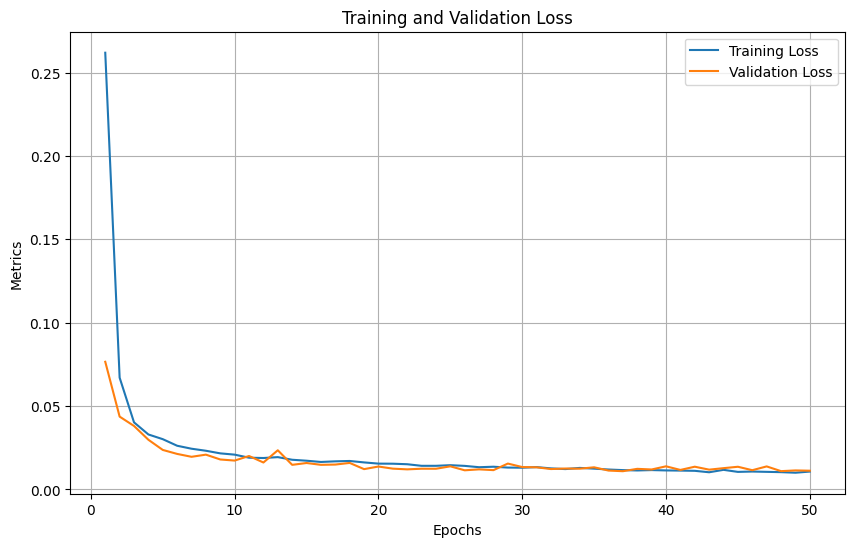

In [7]:
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Initialize lists to store losses, accuracies, and F1 scores
train_losses = []
val_losses = []
val_accuracies = []

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for x_categ, x_numer, labels in train_loader:
        # Move inputs and labels to the device (GPU or CPU)
        x_categ, x_numer, labels = x_categ.to(device), x_numer.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(x_categ, x_numer)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Training Loss: {avg_loss:.4f}")


def validate(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation for validation
        for x_categ, x_numer, labels in val_loader:
            x_categ, x_numer, labels = x_categ.to(device), x_numer.to(device), labels.to(device)

            # Forward pass
            outputs = model(x_categ, x_numer)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # Store predictions and labels for accuracy and F1 calculation
            _, preds = torch.max(outputs, 1)  # Get predicted class
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)

    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)

    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")
    return accuracy

# Training the model over several epochs
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device = {device}')
best_val_acc = 0.0
model.to(device)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train for one epoch
    train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate after each epoch
    val_acc = validate(model, val_loader, criterion, device)

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_ft_transformer_model.pth")
        print("Model saved with better validation accuracy")

# Plotting the results
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')


plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()



In [12]:
from sklearn.metrics import classification_report
import torch

# Function to test the model
def test_model(model, x_test_categ, x_test_numer, y_test, batch_size=64):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    # Convert test data to tensors
    x_test_categ_tensor = torch.tensor(x_test_categ, dtype=torch.long)
    x_test_numer_tensor = torch.tensor(x_test_numer, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoader for batch processing
    test_dataset = torch.utils.data.TensorDataset(x_test_categ_tensor, x_test_numer_tensor, y_test_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():  # No gradient calculation during testing
        for x_categ, x_numer, y in test_loader:
            # Forward pass
            logits = model(x_categ.to(device), x_numer.to(device))
            predictions = torch.argmax(logits, dim=1)  # Get class predictions
            y_true.extend(y.tolist())
            y_pred.extend(predictions.tolist())

    # Calculate classification metrics
    report = classification_report(y_true, y_pred, target_names=label_encoders['label'].classes_)

    # Print the number of parameters in the model
    print(f"Total number of parameters: {count_parameters(model)}")
    print("Classification Report:\n", report)

# Run the test
test_model(model, x_test_categ, x_test_numer, y_test)


Total number of parameters: 17435
Classification Report:
               precision    recall  f1-score   support

         DoS       0.99      0.98      0.99      5741
       Probe       0.72      0.92      0.81      1106
         R2L       0.97      0.12      0.22      2199
         U2R       0.09      0.19      0.12        37
      normal       0.83      0.97      0.89      9711

    accuracy                           0.87     18794
   macro avg       0.72      0.64      0.61     18794
weighted avg       0.89      0.87      0.84     18794



In [13]:
import xgboost as xgb
from sklearn.metrics import classification_report

def train_and_test_baseline(x_train_categ, x_train_numer, y_train, x_test_categ, x_test_numer, y_test):
  # Combine categorical and numerical features for training and testing
  x_train_baseline = np.hstack((x_train_categ, x_train_numer))
  x_test_baseline = np.hstack((x_test_categ, x_test_numer))

  # Convert labels to integers if they are not already
  y_train_baseline = y_train.astype(int)
  y_test_baseline = y_test.astype(int)

  # Create XGBoost DMatrix for better performance
  dtrain = xgb.DMatrix(x_train_baseline, label=y_train_baseline)
  dtest = xgb.DMatrix(x_test_baseline, label=y_test_baseline)

  # Set XGBoost parameters
  params = {
      'objective': 'multi:softmax',  # Use softmax for multi-class classification
      'num_class': num_classes,     # Number of classes
      'eval_metric': 'mlogloss',    # Log loss for evaluation
      'max_depth': 6,               # Max depth of trees
      'eta': 0.3,                   # Learning rate
      'seed': 42                    # Random seed
  }

  # Train the XGBoost model
  num_rounds = 100  # Number of boosting rounds
  bst = xgb.train(params, dtrain, num_rounds)

  # Print the number of parameters in the baseline model
  num_parameters_baseline = sum(tree.count('\n') for tree in bst.get_dump())
  print(f"Total number of baseline parameters: {num_parameters_baseline}")

  # Make predictions
  y_pred = bst.predict(dtest)

  # Detailed classification report
  print("Classification Report:\n", classification_report(y_test, y_pred))

train_and_test_baseline(x_train_categ, x_train_numer, y_train, x_test_categ, x_test_numer, y_test)



Total number of baseline parameters: 17222
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      5741
           1       0.84      1.00      0.91      1106
           2       0.98      0.09      0.16      2199
           3       0.50      0.11      0.18        37
           4       0.82      0.97      0.89      9711

    accuracy                           0.88     18794
   macro avg       0.83      0.63      0.63     18794
weighted avg       0.89      0.88      0.84     18794

